In [1]:
import numpy as np 
import pandas as pd
%matplotlib inline

### New defination of "churn"

In [2]:
transactions_v1 = pd.read_csv('transactions.csv')
transactions_v2 = pd.read_csv('transactions_v2.csv')
transactions = transactions_v1.append(transactions_v2).reset_index(drop=True)
transactions = transactions.sort_values(['msno','transaction_date','membership_expire_date'])current_msno = ''

In [3]:
import datetime
from tqdm import tqdm

In [4]:
#transactions = tran1.append(tran2).reset_index(drop=True)
transactions = transactions.sort_values(['msno','transaction_date','membership_expire_date'])
current_msno = ''

In [5]:
targets = [201702]
msnos = [[] for i in range(len(targets))]
is_churns = [[] for i in range(len(targets))]

is_cancels = []
transaction_dates = []
membership_expire_dates = []

In [6]:
total_rows = len(transactions['msno'])

In [7]:
for i, row in tqdm(transactions.iterrows(), total=total_rows):
    msno = row['msno']
    transaction_date = row['transaction_date']
    membership_expire_date = row['membership_expire_date']
    is_cancel = int(row['is_cancel'])
    if(current_msno != msno or i == total_rows - 1):
        if(current_msno != ''):
            for z, target in enumerate(targets):
                for j in range(len(transaction_dates)-1,-1,-1):
                    l = int(transaction_dates[j]/100)
                    r = int(membership_expire_dates[j]/100)
                    record_index = j
                    if(r == target and is_cancels[j] == 0 and l < target):
                        is_churn = 1
                        expired_date = datetime.datetime.strptime(str(membership_expire_dates[j]), "%Y%m%d")
                        
                        for k in range(j+1,len(transaction_dates)):
                            trans_date = datetime.datetime.strptime(str(transaction_dates[k]), "%Y%m%d")
                            expired_date1 = datetime.datetime.strptime(str(membership_expire_dates[k]), "%Y%m%d")
                            is_cancel = is_cancels[k]
                            dif_d = (trans_date-expired_date).days
                            if(dif_d < 30):
                                if(is_cancel == 0 and expired_date < expired_date1):
                                    is_churn = 0
                            else:
                                break
                        msnos[z].append(current_msno) 
                        is_churns[z].append(is_churn)   
                        break
            
        transaction_dates = []
        membership_expire_dates = []
        is_cancels = []
    
    transaction_dates.append(transaction_date)
    membership_expire_dates.append(membership_expire_date)
    is_cancels.append(is_cancel)
    
    current_msno = msno

100%|██████████| 22978755/22978755 [44:27<00:00, 8613.62it/s] 


In [8]:
for i, target in enumerate(targets):
    out = pd.DataFrame()
    out['msno'] = msnos[i]
    out['is_churn'] = is_churns[i]
    out.to_csv('Desktop/DS5500/kkbox-churn-prediction-challenge/train_v2_final_{}.csv'.format(target), index=False)

In [5]:
train = pd.read_csv('../kkbox-churn-prediction-challenge/train_v2_final_201702.csv')

In [6]:
train.shape

(983439, 2)

### EDA with dermographic features (members)

In [4]:
members = pd.read_csv('../../kkbox-churn-prediction-challenge/original_data/members_v3.csv')

In [5]:
train=pd.read_csv('../../kkbox-churn-prediction-challenge/train_v2_final_201702.csv')

In [6]:
members.shape

(6769473, 6)

In [7]:
members_train = train.merge(members,"left",on="msno")

In [8]:
members_train.shape

(983439, 7)

In [9]:
members_train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,1.0,0.0,NaN,7.0,20140608.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,15.0,26.0,male,9.0,20101118.0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,1.0,0.0,NaN,7.0,20140927.0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,18.0,21.0,male,7.0,20160315.0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,0,22.0,32.0,male,9.0,20120122.0


In [10]:
(train['is_churn'].value_counts()/train['is_churn'].count())*100

0    95.970975
1     4.029025
Name: is_churn, dtype: float64

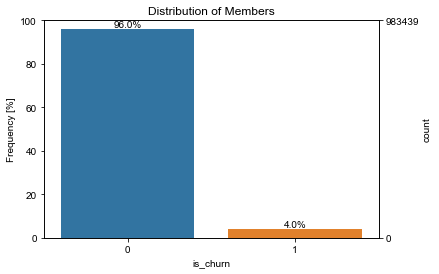

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# The count of churn and not churn
ax=sns.countplot(x="is_churn", data=train)
plt.title('Distribution of Members')
ncount = len(train)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(2))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))
sns.set(rc={'figure.figsize':(10,6)})

plt.show()

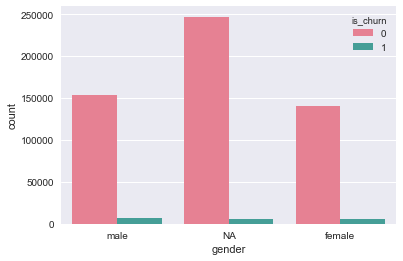

In [10]:
members_train["gender"] = members_train['gender'].fillna('NA')
sns.set(style="darkgrid")
sns.countplot(x="gender", hue="is_churn",data=members_train,palette="husl")
plt.show()

In [13]:
(members_train['gender'].value_counts()/members_train['gender'].count())*100

NA        45.148826
male      28.742607
female    26.108567
Name: gender, dtype: float64

In [11]:
from collections import Counter
gender_count = Counter(members_train['gender']).most_common()
print("Gender Count " +str(gender_count))

Gender Count [('NA', 252977), ('male', 161050), ('female', 146291)]


### Analysis of each column

In [86]:
members_train.dtypes

msno                       object
is_churn                    int64
city                      float64
bd                        float64
gender                     object
registered_via            float64
registration_init_time    float64
dtype: object

In [106]:
members_train.isnull().sum(axis = 0)

msno                           0
is_churn                       0
city                      114781
bd                        114781
gender                         0
registered_via            114781
registration_init_time    114781
dtype: int64

#### bd (age)
Half of the members does not have a valid age

In [14]:
members_train['bd'].max()

2016.0

In [15]:
members_train['bd'].min()

-3152.0

In [102]:
seriesObj = members_train.apply(lambda x: True if x['bd'] <=0 or x['bd']>100 else False , axis=1)
numOfRows = len(seriesObj[seriesObj == True].index)

In [103]:
numOfRows

485682

In [ ]:
# change it, to what?
members_train['bd'] = members_train['bd'].apply(lambda x: [y if y <= 9 else 11 for y in x])

#### city & register_method

In [107]:
members_train["city"] = members_train['city'].fillna('unknown')

In [17]:
(members_train['registered_via'].value_counts()/members_train['registered_via'].count())*100

7.0    48.231748
9.0    35.673810
3.0    14.554372
4.0     1.540071
Name: registered_via, dtype: float64

In [109]:
members_train["registered_via"] = members_train['registered_via'].fillna('unknown')

#### registration_time

In [112]:
members_train['registration_init_time'].max()

20170330.0

In [113]:
members_train['registration_init_time'].min()

20040326.0

In [111]:
members_train.isnull().sum(axis = 0)

msno                           0
is_churn                       0
city                           0
bd                        114781
gender                         0
registered_via                 0
registration_init_time    114781
dtype: int64

### Transactions data

In [117]:
transactions.to_csv('Desktop/DS5500/kkbox-churn-prediction-challenge/transactions_combined_{}.csv'.format(target), index=False)

In [5]:
transactions = pd.read_csv('transactions_combined_201702.csv')

In [6]:
transactions.shape

(22978755, 9)

In [7]:
tran_churn = transactions.merge(train,on='msno',how="inner")

In [132]:
tran_churn.shape

(16925887, 10)

In [9]:
del train

In [11]:
del transactions

In [12]:
tran_churn.isnull().sum(axis = 0) #everything has data, good!

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
is_churn                  0
dtype: int64

In [13]:
stats = tran_churn.groupby(['msno','is_churn']).agg({'actual_amount_paid':['sum'],'payment_plan_days':['mean']})

In [15]:
stats.columns = stats.columns.droplevel(1)

/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


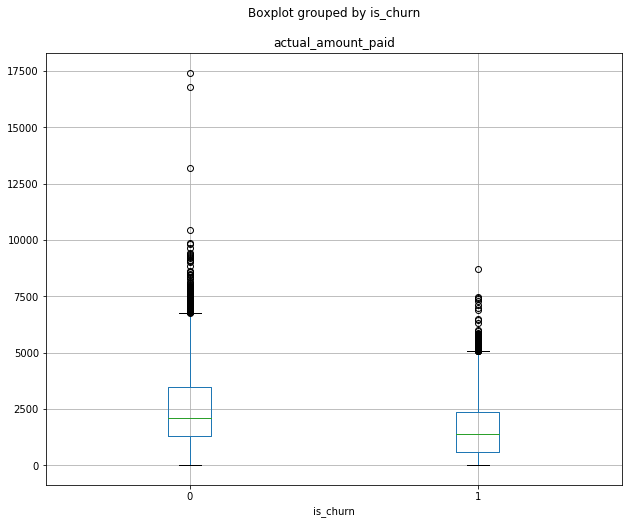

In [18]:
stats.boxplot(column='actual_amount_paid',by='is_churn',figsize=(10,8))

/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


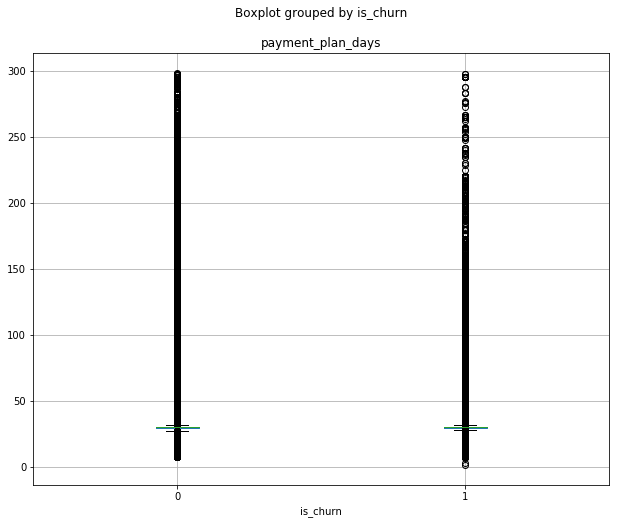

In [20]:
stats[stats['payment_plan_days']<300].boxplot(column='payment_plan_days',by='is_churn',figsize=(10,8))

In [137]:
tran_churn.dtypes

msno                      object
payment_method_id          int64
payment_plan_days          int64
plan_list_price            int64
actual_amount_paid         int64
is_auto_renew              int64
transaction_date           int64
membership_expire_date     int64
is_cancel                  int64
is_churn                   int64
dtype: object

In [134]:
(tran_churn['payment_plan_days'].value_counts()/tran_churn['payment_plan_days'].count())*100
# most people pay every 30 days

30     92.826657
0       3.525464
31      2.736294
7       0.288481
195     0.166845
410     0.113276
180     0.071677
90      0.069497
100     0.041457
120     0.039041
10      0.029499
60      0.019585
1       0.017009
360     0.011923
395     0.011409
200     0.008797
240     0.005985
400     0.004591
14      0.003498
365     0.002032
35      0.001607
450     0.001377
70      0.001128
80      0.000614
270     0.000502
21      0.000502
99      0.000396
66      0.000331
230     0.000183
415     0.000130
110     0.000112
3       0.000041
15      0.000024
45      0.000018
2       0.000018
Name: payment_plan_days, dtype: float64

In [135]:
(tran_churn['payment_method_id'].value_counts()/tran_churn['payment_method_id'].count())*100
# most people pay by method 41

41    59.167912
40     9.771996
39     7.389143
37     4.828645
38     4.543053
34     4.029999
36     3.834576
33     1.961315
31     1.392660
30     0.677820
29     0.528752
27     0.271117
35     0.238818
32     0.233642
23     0.213738
28     0.188681
19     0.182141
21     0.114995
18     0.082826
14     0.074767
24     0.054538
16     0.048057
20     0.047418
22     0.024265
25     0.021405
26     0.017210
15     0.012762
11     0.011344
13     0.010948
17     0.009867
12     0.006865
10     0.006475
8      0.001075
6      0.000402
5      0.000378
3      0.000325
2      0.000059
4      0.000012
Name: payment_method_id, dtype: float64